### 1) Load Test Results

In [2]:
import os
import pandas as pd
import json

# Function to clean and process each line to remove noise and keep only JSON content
def preprocess_line(line):
    try:
        return json.loads(line)
    except json.JSONDecodeError:
        return None

# Get a list of all log files in the directory
log_files = [f for f in os.listdir() if f.endswith('.log')]

# Create a dictionary to hold all dataframes
dfs = {}

for file in log_files:
    data = []
    with open(file, 'r') as f:
        for line in f:
            # Preprocess each line to remove noise
            processed_line = preprocess_line(line)
            if processed_line is not None:
                data.append(processed_line)
    
    # Convert the processed data to a DataFrame
    df = pd.json_normalize(data, sep='_')

    # Remove the .log extension and use the filename as the key in the dictionary
    dfs[file[:-4]] = df

# Example of accessing a DataFrame (you can adjust based on your needs)
for key, df in dfs.items():
    print(f"DataFrame for {key}:")
    print(df.head())
    

# Print the number of test runs
print(f"Number of test runs: {len(dfs)}")

# Print the name of each test run
for name in dfs.keys():
    print(name)

DataFrame for paygo-gpt35-eastus-4RPM-2-error:
   run_seconds            timestamp   rpm  processing  completed  failures  \
0            1  2024-08-01 10:25:10   n/a           2          0         0   
1            2  2024-08-01 10:25:11   n/a           2          0         0   
2            3  2024-08-01 10:25:12   n/a           2          0         0   
3            4  2024-08-01 10:25:13  30.0           0          2         0   
4            5  2024-08-01 10:25:14  24.0           1          2         0   

   throttled  requests context_tpr_avg tpm_context  ... e2e_95th  ttft_avg  \
0          0         0             n/a         n/a  ...      n/a       n/a   
1          0         0             n/a         n/a  ...      n/a       n/a   
2          0         0             n/a         n/a  ...      n/a       n/a   
3          0         2            3260     97800.0  ...    3.452     0.989   
4          0         2            3260     78240.0  ...    3.452     0.989   

  ttft_95th tbt

### 2) Summarize Test Runs

In [4]:
from tabulate import tabulate

# Create a list to hold the last row of each DataFrame
summary_data = []

for name, df in dfs.items():
    # Check if the DataFrame is empty
    if not df.empty:
        # Get the last row of the DataFrame
        last_row = df.iloc[-1:]
        
        # Add the name of the DataFrame as the first column
        last_row.insert(0, 'DataFrame', name)
    
        # Append the last row to the summary_data list
        summary_data.append(last_row)

# Convert the list of last rows into a DataFrame
summary_df = pd.concat(summary_data)

# Print summary_df in a tabular format
print('Execution Summary:')
print(tabulate(summary_df, headers='keys', tablefmt='psql', showindex=False))

Execution Summary:
+---------------------------------+---------------+---------------------+-------+--------------+-------------+------------+-------------+------------+-------------------+---------------+-----------+-------------+-----------+------------+------------+-------------+-----------+------------+----------------+---------------+----------------+------------+-------------+
| DataFrame                       |   run_seconds | timestamp           |   rpm |   processing |   completed |   failures |   throttled |   requests |   context_tpr_avg |   tpm_context |   tpm_gen |   tpm_total |   e2e_avg |   e2e_95th |   ttft_avg |   ttft_95th |   tbt_avg |   tbt_95th |   gen_tpr_10th |   gen_tpr_avg |   gen_tpr_90th | util_avg   | util_95th   |
|---------------------------------+---------------+---------------------+-------+--------------+-------------+------------+-------------+------------+-------------------+---------------+-----------+-------------+-----------+------------+----------

### 3) Create some trend charts

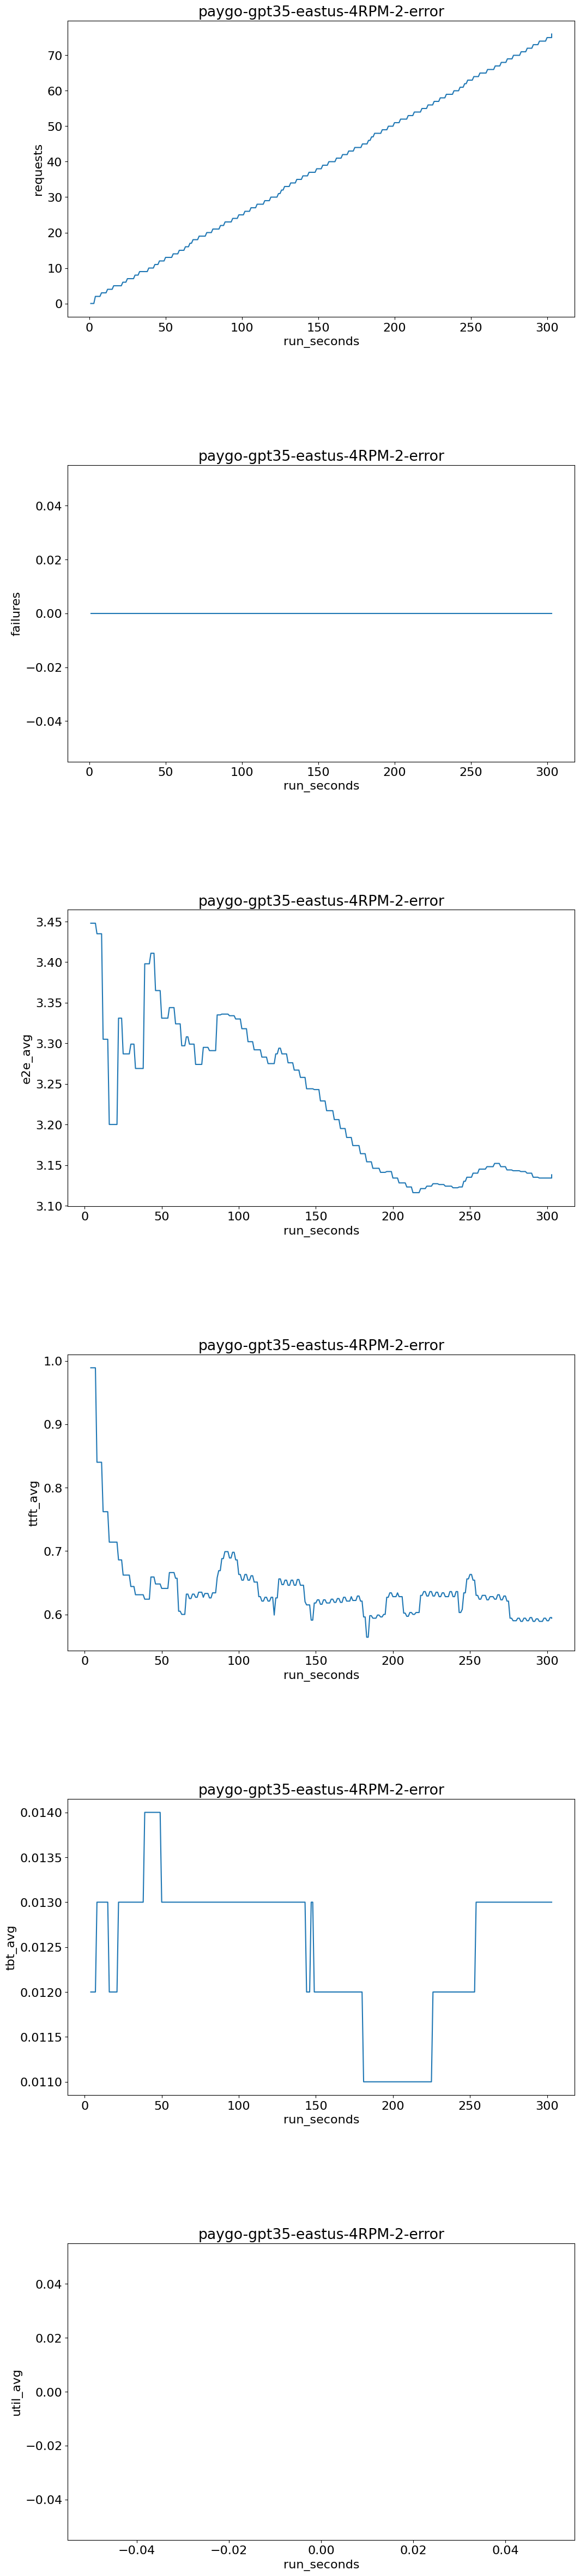

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Increase the global font size
plt.rcParams.update({'font.size': 16})

# List of fields to plot
fields = ['requests', 'failures', 'e2e_avg', 'ttft_avg', 'tbt_avg', 'util_avg']

# Determine the number of rows and columns for the subplots
nrows = len(fields)
ncols = len(dfs)

# Increase the height of each chart to 10 inches
fig, axs = plt.subplots(nrows, ncols, figsize=(2 * ncols * 6, nrows * 10))
fig.subplots_adjust(hspace=0.5)

# Loop over each field, each dataframe, and each axes
for i, field in enumerate(fields):
    for j, (name, df) in enumerate(dfs.items()):
        # Check if 'run_seconds' and field exist in df
        if 'run_seconds' in df.columns and field in df.columns:
            # Convert 'run_seconds' and field to numeric type and drop rows with NaN values
            df['run_seconds'] = pd.to_numeric(df['run_seconds'], errors='coerce')
            df[field] = pd.to_numeric(df[field], errors='coerce')
            df = df.dropna(subset=['run_seconds', field])

            # Create a line plot on each axes
            if ncols > 1:
                ax = axs[i, j]
            else:
                ax = axs[i]

            ax.plot(df['run_seconds'], df[field])

            # Set the title of the plot to the name of the dataframe
            ax.set_title(name)

            # Set the labels for the x-axis and y-axis
            ax.set_xlabel('run_seconds')
            ax.set_ylabel(field)
        else:
            print(f"'run_seconds' or '{field}' not found in DataFrame {name}")

# Display the plots
plt.show()